[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Kalman Filter Math

In [1]:
#format the book
%matplotlib inline
from __future__ import division, print_function
from book_format import load_style
load_style()

If you've gotten this far I hope that you are thinking that the Kalman filter's fearsome reputation is somewhat undeserved. Sure, I hand waved some equations away, but I hope implementation has been fairly straightforward for you. The underlying concept is quite straightforward - take two measurements, or a measurement and a prediction, and choose the output to be somewhere between the two. If you believe the measurement more your guess will be closer to the measurement, and if you believe the prediction is more accurate your guess will lie closer it it. That's not rocket science (little joke - it is exactly this math that got Apollo to the moon and back!). 

To be honest I have been choosing my problems carefully. For an arbitrary problem designing the Kalman filter matrices can be extremely difficult. I haven't been *too tricky*, though. Equations like Newton's equations of motion can be trivially computed for Kalman filter applications, and they make up the bulk of the kind of problems that we want to solve. 

I have illustrated the concepts with code and reasoning, not math. But there are topics that do require more mathematics than I have used so far. This chapter presents the math that you will need for the rest of the book.

## Modeling a Dynamic System that Has Noise

A *dynamic system* is a physical systems whose state evolves over time. Modeling dynamic systems is properly the topic of several undergraduate and graduate courses in mathematics. To an extent there is no substitute for a few semesters of ordinary and partial differential equations followed by a graduate course in control sytem theory. If you are a hobbyist, or trying to solve one very specific filtering problem at work you probably do not have the time and/or inclination to devote a year or more to that education.

However, I can present enough of the theory to allow us to create the system equations for many different Kalman filters, and give you enough background to at least follow the mathematics in the literature. My goal is to get you to the stage where you can read a Kalman filtering book or paper and understand it well enough to implement the algorithms. The background math is deep, but we end up using a few simple techniques over and over again in practice.

We need to start by understanding the underlying equations and assumptions that the Kalman filter uses. We are trying to model real world phenomena, so what do we have to consider?

Each physical system has a process. For example, a car traveling at a certain velocity goes so far in a fixed amount of time, and its velocity varies as a function of its acceleration. We describe that behavior with the well known Newtonian equations we learned in high school.

$$
\begin{aligned}
v&=at\\
x &= \frac{1}{2}at^2 + v_0t + d_0
\end{aligned}
$$

And once we learned calculus we saw them in this form:

$$
\begin{aligned}
 \mathbf v &= \frac{d \mathbf x}{d t}\\ 
 \quad \mathbf{a} &= \frac{d \mathbf v}{d t} \\
 &= \frac{d^2 \mathbf x}{d t^2} \,\!
\end{aligned}
 $$
 
Accurately modeling a system is impossible for anything but the most trivial problem. A typical automobile tracking problem would have you compute the distance traveled given a constant velocity or acceleration. But, of course we know this is not all that is happening. No car travels on a perfect road. There are bumps that cause the car to slow down, there is wind drag, there are hills that raise and lower the speed. The suspension is a mechanical system with friction and imperfect springs. We have no way to measure or model wind gusts. 

So control theory is forced to make a simplification. At any time $t$ we say that the actual value (such as the position of our car) is the predicted value from the imperfect model plus some unknown *process noise*:

$$
x(t) = x_{pred}(t) + noise(t)
$$

This is not meant to imply that $noise(t)$ is a function that we can derive analytically or that it is well behaved. If there is a bump in the road at $t=10$ then the noise factor will incorporate that effect. Again, this is not implying that we model, compute, or even know the value of $noise(t)$, it is merely a statement of fact - we can always describe the actual value as the predicted value from our idealized model plus some other value. Also "noise" does not imply random events. If we are modeling a thrown ball, and our model assumes the ball is in a vacuum, then the effect of air drag is process noise in this context.

In the next section we will learn techniques to convert a set of differential equations into a set of linear equations.  Using the same notation from previous chapters, we can say that our model of the system without noise is:

$$ f(\mathbf x) = \mathbf{Ax}$$

That is, we have a set of linear equations that describe our system. For our car, 
$\mathbf A$ will be the coefficients for Newton's equations of motion. 

Now we need to model the noise. We will call that *w*, and add it to the equation.

$$ f(\mathbf x) = \mathbf{Ax} + \mathbf w$$

Finally, we need to consider inputs into the system. We are dealing with linear problems here, so we will assume that there is some input $u$ into the system, and that we have some linear model that defines how that input changes the system. For example, pressing the accelerator in your car makes it accelerate, and gravity causes balls to fall. Both are contol inputs. We will need a matrix $\mathbf B$ to convert $u$ into the effect on the system. We add that into our equation:

$$ f(\mathbf x) = \mathbf{Ax} + \mathbf{Bu} + \mathbf{w}$$

And that's it. That is one of the equations that Dr. Kalman set out to solve, and he found a way to compute an optimal solution if we assume certain properties of $w$.

## State-Space Representations of Dynamic Systems

The equation $\mathbf{v} = \frac{d \mathbf x}{d t}$ is the simplest possible differential equation. We trivially integrate it into the high school physics equation $x = v\Delta t + x_0$. We then use a computer to compute the position $\mathbf x$ for any arbitrary time step $\Delta t$. We call this equation *discretized* because we can compute the state for a discrete time step $\Delta t$. Almost all other differential equations encountered in physical systems will not yield to this approach. 

*State-space* methods became popular around the time of the Apollo missions, largely due to the work of Dr. Kalman. The idea is simple. Start with a system of $n^{th}$-order differential equations which model a dynamic system. Next, convert the equations into an equivalent set of first-order differential equations. We can then represent that set of first order equations in vector matrix form. These equations are continuous. We wish to computes these equations with a computer, so we use another technique to *discretize* the equations. Once in this form we use the formidable powers of linear algebra to solve the system of equations. The Kalman filter is an example of this power. 

This presentation and this book is limited to dynamic systems can be represented with differential equation. Not all systems can be represented in this form. *Hybrid System Theory* tackles those sorts of systems.

Let's put this into mathematical notation. We have a $n^{th}$-order differential equation with control input $u$ which describes our system:

$$a_n \frac{d^ny}{dt^n} + a_{n-1} \frac{d^{n-1}y}{dt^{n-1}} +  \dots + a_2 \frac{d^2y}{dt^2} + a_1 \frac{dy}{dt} + a_0 = u$$

We can convert this system into a set of first order equations using a technique I will explain later:

$$\frac{dx_1}{dt} = x_2\\
\frac{dx_2}{dt} = x_3 \\
\vdots \\
\frac{dx_{n-1}}{dt} = x_n \\
\frac{dx_n}{dt} = \frac{1}{a_n}\sum\limits_{i=0}^{n-1}a_ix_{i+1} + \frac{1}{a_n}u
$$

Using vector-matrix notation we have:

$$\begin{bmatrix}\frac{dx_1}{dt} \\ \frac{dx_2}{dt} \\ \vdots \\ \frac{dx_n}{dt}\end{bmatrix} = 
\begin{bmatrix}0 & 1 & 0 &\cdots & 0 \\
0 & 0 & 1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
-\frac{a_0}{a_n} & -\frac{a_1}{a_n} & -\frac{a_2}{a_n} & \cdots & -\frac{a_{n-1}}{a_n}\end{bmatrix}
\begin{bmatrix}x_1 \\ x_2 \\ \vdots \\ x_n\end{bmatrix} + 
\begin{bmatrix}0 \\ 0 \\ \vdots \\ \frac{1}{a_n}\end{bmatrix}u$$

which we then write as

$$\frac{d\mathbf x}{dt} = \mathbf{Ax} + \mathbf{bu}$$

which you will recognize this form from the previous section. We are interested in the state $\mathbf x$, not $\frac{d\mathbf x}{dt}$, so we will need a technique to find the *fundamental matrix* $\Phi$ for that first order differential equation. The fundamental matrix discretizes the differential equation by propogating the system state from time $t_0$ to time $t_1$ with the recursive equation:

$$\mathbf x(t) = \Phi(t_1-t_0)\mathbf x(t_0)$$

$\Phi$ is the state transition function matrix $\mathbf{F}$ that we use in the Kalman filter predict step.

### Why This is Hard

I asserted that we can model dynamic systems with a set of first order differential equations. For example, we already presented the Newtonian equation

$$\mathbf{v}= \frac{d \mathbf x}{d t} = \dot{\mathbf x}$$

In general terms we can then say that a dynamic system consists of equations of the form

$$ g(t) = \dot x$$

if the behavior of the system depends on time. However, if the system is *time invariant* the equations are of the form

$$ f(x) = \dot x$$

What does *time invariant* mean? Consider a home stereo. If you input a signal $x$ into it at time $t$, it will output some signal $f(x)$. If you instead perform the input at time $t + \Delta t$ the output signal will be the same except shifted in time. A counterexample is $x(t) = \sin(t)$, and the sytem is $f(x) = t\times x(t) = t \sin(t)$. This is not time invariant; the value will be different at different times due to the multiplication by t.  An aircraft is not time invariant. If you make a control input to the aircraft at a later time it's behavior will be different because it will have burned additional fuel and thus lost weight, drag may be different due to being at a different altitude, and so on.

We can solve these equations by integrating each side. The time variant equation is very straightforward. Starting with 

$$\dot{\mathbf x}=\mathbf{v}$$ we get the expected

$$ \int \dot{\mathbf x}\mathrm{d}t = \int \mathbf{v} \mathrm{d}t\\
x = vt + x_0$$

However, integrating the time invariant equation is not so straightforward. 

$$ \dot x = f(x) \\
\frac{dx}{dt} = f(x)
$$ 

Using the *separation of variables* techniques we divide by $f(x)$ and move the $dt$ term to the right so we can integrate each side:

$$
\int^x_{x_0} \frac{1}{f(x)} dx = \int^t_{t_0} dt\\
$$

If we name $\int \frac{1}{f(x)} dx$ as $F(x)$, we get

$$F(x) - F(x_0) = t-t_0$$

We then solve for x with

$$F(x) = t - t_0 + F(x_0) \\
x = F^{-1}[t-t_0 + F(x_0)]$$

In other words, we need to find the inverse of $F$. This is not at all trivial, and a significant amount of coursework in a STEM education is devoted to finding tricky, analytic solutions to this problem. 

However, they are tricks, and many simple forms of $f(x)$ either have no closed form solution or pose extreme difficulties. Instead, the practicing engineer turns to state-space methods to find solutions.

### Forming First Order Equations from Higher Order Equations

Many models of physical systems require second or higher order equations. State-space methods require first-order differential equations. Any higher order system of equations can be converted to a first order set of equations by defining extra variables for the first order terms and then solving. 

Let's do an example. Given the system $\ddot{x} - 6\dot x + 9x = t$ find the first order equations.

The first step is to isolate the highest order term onto one side of the equation .

$$\ddot{x} = 6\dot x - 9x + t$$

We define two new variables:

$$ x_1(t) = x \\
x_2(t) = \dot x
$$

Now we will substitute these into the original equation and solve, giving us a set of first order equations in terms of these new variables. It is conventional to drop the $(t)$ for notational convenience.

First, we know that $\dot x_1 = x_2$ and that $\dot x_2 = \ddot{x}$. Therefore

$$\begin{aligned}
\dot x_2 &= \ddot{x} \\
          &= 6\dot x - 9x + t\\
          &= 6x_2-9x_1 + t
\end{aligned}$$

Therefore our first order system of equations is

$$\begin{aligned}\dot x_1 &= x_2 \\
\dot x_2 &= 6x_2-9x_1 + t\end{aligned}$$

If you practice this a bit you will become adept at it. Isolate the highest term, define a new variable and its derivatives, and then substitute.

### Finding the Fundamental Matrix for Time Invariant Systems

We express the system equations in state-space form (i.e. using linear algebra equations) with

$$ \dot{\mathbf x} = \mathbf{Ax}$$

Now we assert that we want to find the *fundamental matrix* $\Phi$ that propagates the state $\mathbf x$ with the equation

$$\mathbf x(t_1) = \Phi(t_1-t_0)\mathbf x(t_0)$$

which we can equivalently write as

$$\mathbf x(t_k) = \Phi(\Delta t)\mathbf x(t_{k-1})$$

You will recognize as the state transition matrix we use in the prediction step of the Kalman filter. We want to compute the value of $\mathbf x$ at time $t$ by multiplying its previous value by some matrix $\Phi$.

It is conventional to drop the $t_k$ and use the notation

$$\mathbf x_k = \Phi(\Delta t)\mathbf x_{k-1}$$

$\mathbf x_k$ does not mean the k$^{th}$ value of $\mathbf x$, but the value of $\mathbf x$ at the k$^{th}$ value of $t$.

Broadly speaking there are three common ways to find this matrix for Kalman filters. The technique most often used with Kalman filters is to use a Taylor-series expansion. Linear Time Invariant Theory, also known as LTI System Theory, is a second technique. Finally, there are numerical techniques. You may know of others, but these three are what you will most likely encounter in the Kalman filter literature and praxis.

### Taylor Series Expansion

Taylor series represents a function as an infinite sum of terms. The terms are linear, even for a nonlinear function, so we can express any arbitrary nonlinear function using linear algebra. The cost of this choice is that unless we use an infinite number of terms the value we compute will be approximate rather than exact.

For a real or complex function the Taylor series of a function $f(x)$ evaluated at $t$ is defined as 

$$ \Phi(t) = e^{\mathbf{F}t} = \mathbf{I} + \mathbf{F}t  + \frac{(\mathbf{F}t)^2}{2!} + \frac{(\mathbf{F}t)^3}{3!} + ... $$

This is easy to compute, and thus is the typical approach used in Kalman filter design when the filter is reasonably small. If you are wondering where $e$ came from, I point you to the Wikipedia article on the matrix exponential [1]. Here the important point is to recognize the very simple and regular form this equation takes. 

Before applying it to a matrix lets do the Taylor expansion of a real function since this is much easier to visualize. I choose sin(x). The Taylor series for a real or complex function f(x) about x=a is

$$f(x) = \sum_{n=0}^\infty\frac{f^{(n)}(a)}{x!}(x-a)^n$$

where $f^{n}$ is the nth derivative of f. To compute the Taylor series for $f(x)=sin(x)$ at $x=0$ Let's first work out the terms for f.

$$\begin{aligned}
f^{0}(x) &= sin(x) ,\ \  &f^{0}(0) &= 0 \\
f^{1}(x) &= cos(x),\ \  &f^{1}(0) &= 1 \\
f^{2}(x) &= -sin(x),\ \  &f^{2}(0) &= 0 \\
f^{3}(x) &= -cos(x),\ \  &f^{3}(0) &= -1 \\
f^{4}(x) &= sin(x),\ \  &f^{4}(0) &= 0 \\
f^{5}(x) &= cos(x),\ \  &f^{5}(0) &= 1
\end{aligned}
$$

Now we can substitute these values into the equation.

$$\sin(x) = \frac{0}{0!}(x)^0 + \frac{1}{1!}(x)^1 + \frac{0}{2!}(x)^2 + \frac{-1}{3!}(x)^3 + \frac{0}{4!}(x)^4 + \frac{-1}{5!}(x)^5 + ... $$

And let's test this with some code:

In [2]:
import numpy as np

x = .3
estimate = x + x**3/6 + x**5/120
exact = np.sin(.3)

print('estimate of sin(.3) is', estimate)
print('exact value of sin(.3) is', exact)

estimate of sin(.3) is 0.30452025
exact value of sin(.3) is 0.295520206661


This is not bad for only three terms. If you are curious, go ahead and implement this as a Python function to compute the series for an arbitrary number of terms. But I will forge ahead to the matrix form of the equation. 

Let's consider tracking an object moving in a vacuum. In one dimension the differential equation for motion with zero acceleration is

$$ v = \dot x\\a=\ddot{x} =0,$$

which we can put in state-space matrix form as

$$\begin{bmatrix}\dot x \\ \ddot{x}\end{bmatrix} =\begin{bmatrix}0&1\\0&0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}$$

This is a first order differential equation, so we can set $\mathbf{F}=\begin{bmatrix}0&1\\0&0\end{bmatrix}$ and solve the following equation.

$$\Phi(t) = e^{\mathbf{F}t} = \mathbf{I} + \mathbf{F}t  + \frac{(\mathbf{F}t)^2}{2!} + \frac{(\mathbf{F}t)^3}{3!} + ... $$

If you perform the multiplication you will find that $\mathbf{F}^2=\begin{bmatrix}0&0\\0&0\end{bmatrix}$, which means that all higher powers of $\mathbf{F}$ are also $\mathbf{0}$. Thus we get an exact answer without an infinite number of terms:

$$
\begin{aligned}
\Phi(t) &=\mathbf{I} + \mathbf{F}t + \mathbf{0} \\
&= \begin{bmatrix}1&0\\0&1\end{bmatrix} + \begin{bmatrix}0&1\\0&0\end{bmatrix}t\\
&= \begin{bmatrix}1&t\\0&1\end{bmatrix}
\end{aligned}$$

We plug this into $x(t_k) = \Phi(\Delta t)x(t_{k-1})$ to get

$$
\begin{aligned}
x(t_k) &= \Phi(\Delta t)x(t_{k-1}) \\
\overline x &= \Phi(\Delta t)x \\
\overline x &=\begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}x \\
\overline{\begin{bmatrix}x \\ \dot x\end{bmatrix}} &=\begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}\begin{bmatrix}x \\ \dot x\end{bmatrix}
\end{aligned}$$

This should look very familiar to you! This is the equation we used in the **Multivariate Kalman Filter** chapter to track a moving object.

$$
\overline{{\begin{bmatrix}x\\\dot x\end{bmatrix}}} =\begin{bmatrix}1&\Delta t \\ 0&1\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}
$$

We derived this equation in that chapter by using techniques that are much easier to understand. The advantage of the Taylor series expansion is that we can use it for any arbitrary set of differential equations which are time invariant. 

However, we often use a Taylor expansion even when the equations are not time invariant. As an aircraft flies it loses weight as it burns fuel. The answer will still be reasonably accurate so long as the time step is short and the system is nearly constant over that time step. The weight loss is neglible over one second, so the Taylor expansion will be sufficiently accurate for our purposes.

### Linear Time Invariant Theory

*Linear Time Invariant Theory*, also known as LTI System Theory, gives us a way to find $\Phi$ using the inverse Laplace transform. You are either nodding your head now, or completely lost. Don't worry, I will not be using the Laplace transform in this book except in this paragraph, as the computation can be quite difficult. LTI system theory tells us that 

$$ \Phi(t) = \mathcal{L}^{-1}[(s\mathbf{I} - \mathbf{F})^{-1}]$$

I have no intention of going into this other than to say that the inverse Laplace transform $\mathcal{L}^{-1}$ converts a signal into the frequency (time) domain, but finding a solution to the equation above is non-trivial. If you are interested, the Wikipedia article on LTI system theory provides an introduction [2]. I mention LTI because you will find some literature using it to design the Kalman filter matrices for difficult problems. 

### Numerical Solutions

Finally, there are numerous numerical techniques to find $\Phi$. As filters get larger finding analytical solutions becomes very tedious (though packages like SymPy make it easier). C. F. van Loan [3] has developed a technique that finds both $\Phi$ and $\mathbf Q$ numerically. Given the continuous model

$$ x' = Fx + Gu$$

where $u$ is the unity white noise, van Loan's method computes the $\Phi$ and $\mathbf Q_k$ which discretizes that equation.
    
I have implemented van Loan's method in `FilterPy`. You may use it as follows:

```python
from filterpy.common import van_loan_discretization

F = np.array([[0., 1.], [-1., 0.]])
G = np.array([[0.], [2.]]) # white noise scaling
phi, Q = van_loan_discretization(F, G, dt=0.1)
```
    
In the section *Numeric Integration of Differential Equations* I present alternative methods which are very commonly used in Kalman filtering.

## Design of the Process Noise Matrix

In general the design of the $\mathbf Q$ matrix is among the most difficult aspects of Kalman filter design. This is due to several factors. First, the math requires a good foundation in signal theory. Second, we are trying to model the noise in something for which we have little information. Consider trying to model the process noise for a thrown baseball. We can model it as a sphere moving through the air, but that leave many unknown factors - the wind, ball rotation and spin decay, the coefficient of drag of a ball with stitches, the effects of wind and air density, and so on. We develop the equations for an exact mathematical solution for a given process model, but since the process model is incomplete the result for $\mathbf Q$ will also be incomplete. This has a lot of ramifications for the behavior of the Kalman filter. If $\mathbf Q$ is too small then the filter will be overconfident in its prediction model and will diverge from the actual solution. If $\mathbf Q$ is too large than the filter will be unduly influenced by the noise in the measurements and perform sub-optimally. In practice we spend a lot of time running simulations and evaluating collected data to try to select an appropriate value for $\mathbf Q$. But let's start by looking at the math.


Let's assume a kinematic system - some system that can be modeled using Newton's equations of motion. We can make a few different assumptions about this process. 

We have been using a process model of

$$ f(\mathbf x) = \mathbf{Fx} + \mathbf{w}$$

where $\mathbf{w}$ is the process noise. Kinematic systems are *continuous* - their inputs and outputs can vary at any arbitrary point in time. However, our Kalman filters are *discrete*. We sample the system at regular intervals. Therefore we must find the discrete representation for the noise term in the equation above. This depends on what assumptions we make about the behavior of the noise. We will consider two different models for the noise.

### Continuous White Noise Model

We model kinematic systems using Newton's equations. We have either used position and velocity, or position, velocity, and acceleration as the models for our systems. There is nothing stopping us from going further - we can model jerk, jounce, snap, and so on. We don't do that normally because adding terms beyond the dynamics of the real system degrades the estimate. 

Let's say that we need to model the position, velocity, and acceleration. We can then assume that acceleration is constant for each discrete time step. Of course, there is process noise in the system and so the acceleration is not actually constant. The tracked object will alter the acceleration over time due to external, unmodeled forces. In this section we will assume that the acceleration changes by a continuous time zero-mean white noise $w(t)$. In other words, we are assuming that velocity is acceleration changing by small amounts that over time average to 0 (zero-mean). 

Since the noise is changing continuously we will need to integrate to get the discrete noise for the discretization interval that we have chosen. We will not prove it here, but the equation for the discretization of the noise is

$$\mathbf Q = \int_0^{\Delta t} \Phi(t)\mathbf{Q_c}\Phi^\mathsf{T}(t) dt$$

where $\mathbf{Q_c}$ is the continuous noise. This gives us

$$\Phi = \begin{bmatrix}1 & \Delta t & {\Delta t}^2/2 \\ 0 & 1 & \Delta t\\ 0& 0& 1\end{bmatrix}$$

for the fundamental matrix, and

$$\mathbf{Q_c} = \begin{bmatrix}0&0&0\\0&0&0\\0&0&1\end{bmatrix} \Phi_s$$

for the continuous process noise matrix, where $\Phi_s$ is the spectral density of the white noise.

We could carry out these computations ourselves, but I prefer using SymPy to solve the equation.

$$\mathbf{Q_c} = \begin{bmatrix}0&0&0\\0&0&0\\0&0&1\end{bmatrix} \Phi_s$$



In [3]:
import sympy
from sympy import (init_printing, Matrix,MatMul, 
                   integrate, symbols)

init_printing(use_latex='mathjax')
dt, phi = symbols('\Delta{t} \Phi_s')
F_k = Matrix([[1, dt, dt**2/2],
              [0,  1,      dt],
              [0,  0,       1]])
Q_c = Matrix([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1]])*phi

Q=sympy.integrate(F_k * Q_c * F_k.T, (dt, 0, dt))

# factor phi out of the matrix to make it more readable
Q = Q / phi
sympy.MatMul(Q, phi)

⎡         5           4           3⎤       
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥       
⎢──────────  ──────────  ──────────⎥⋅\Phi_s
⎢    20          8           6     ⎥       
⎢                                  ⎥       
⎢         4           3           2⎥       
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥       
⎢──────────  ──────────  ──────────⎥       
⎢    8           3           2     ⎥       
⎢                                  ⎥       
⎢         3           2            ⎥       
⎢\Delta{t}   \Delta{t}             ⎥       
⎢──────────  ──────────  \Delta{t} ⎥       
⎣    6           2                 ⎦       

For completeness, let us compute the equations for the 0th order and 1st order equations.

In [4]:
F_k = sympy.Matrix([[1]])
Q_c = sympy.Matrix([[phi]])

print('0th order discrete process noise')
sympy.integrate(F_k*Q_c*F_k.T,(dt, 0, dt))

0th order discrete process noise


[\Delta{t}⋅\Phi_s]

In [5]:
F_k = sympy.Matrix([[1, dt],
                    [0, 1]])
Q_c = sympy.Matrix([[0, 0],
                    [0, 1]])*phi

Q = sympy.integrate(F_k * Q_c * F_k.T, (dt, 0, dt))

print('1st order discrete process noise')
# factor phi out of the matrix to make it more readable
Q = Q / phi
sympy.MatMul(Q, phi)

1st order discrete process noise


⎡         3           2⎤       
⎢\Delta{t}   \Delta{t} ⎥       
⎢──────────  ──────────⎥⋅\Phi_s
⎢    3           2     ⎥       
⎢                      ⎥       
⎢         2            ⎥       
⎢\Delta{t}             ⎥       
⎢──────────  \Delta{t} ⎥       
⎣    2                 ⎦       

### Piecewise White Noise Model

Another model for the noise assumes that the that highest order term (say, acceleration) is constant for the duration of each time period, but differs for each time period, and each of these is uncorrelated between time periods. In other words there is a discontinuous jump in acceleration at each time step. This is subtly different than the model above, where we assumed that the last term had a continuously varying noisy signal applied to it.  

We will model this as

$$f(x)=Fx+\Gamma w$$

where $\Gamma$ is the *noise gain* of the system, and $w$ is the constant piecewise acceleration (or velocity, or jerk, etc). 

Lets start by looking at a first order system. In this case we have the state transition function

$$\mathbf{F} = \begin{bmatrix}1&\Delta t \\ 0& 1\end{bmatrix}$$

In one time period, the change in velocity will be $w(t)\Delta t$, and the change in position will be $w(t)\Delta t^2/2$, giving us

$$\Gamma = \begin{bmatrix}\frac{1}{2}\Delta t^2 \\ \Delta t\end{bmatrix}$$

The covariance of the process noise is then

$$Q = \mathbb E[\Gamma w(t) w(t) \Gamma^\mathsf{T}] = \Gamma\sigma^2_v\Gamma^\mathsf{T}$$.

We can compute that with SymPy as follows

In [6]:
var=symbols('sigma^2_v')
v = Matrix([[dt**2 / 2], [dt]])

Q = v * var * v.T

# factor variance out of the matrix to make it more readable
Q = Q / var
sympy.MatMul(Q, var)

⎡         4           3⎤    
⎢\Delta{t}   \Delta{t} ⎥    
⎢──────────  ──────────⎥⋅σ²ᵥ
⎢    4           2     ⎥    
⎢                      ⎥    
⎢         3            ⎥    
⎢\Delta{t}            2⎥    
⎢──────────  \Delta{t} ⎥    
⎣    2                 ⎦    

The second order system proceeds with the same math.


$$\mathbf{F} = \begin{bmatrix}1 & \Delta t & {\Delta t}^2/2 \\ 0 & 1 & \Delta t\\ 0& 0& 1\end{bmatrix}$$

Here we will assume that the white noise is a discrete time Wiener process. This gives us

$$\Gamma = \begin{bmatrix}\frac{1}{2}\Delta t^2 \\ \Delta t\\ 1\end{bmatrix}$$

There is no 'truth' to this model, it is just convenient and provides good results. For example, we could assume that the noise is applied to the jerk at the cost of a more complicated equation. 

The covariance of the process noise is then

$$Q = \mathbb E[\Gamma w(t) w(t) \Gamma^\mathsf{T}] = \Gamma\sigma^2_v\Gamma^\mathsf{T}$$.

We can compute that with SymPy as follows

In [7]:
var=symbols('sigma^2_v')
v = Matrix([[dt**2 / 2], [dt], [1]])

Q = v * var * v.T

# factor variance out of the matrix to make it more readable
Q = Q / var
sympy.MatMul(Q, var)

⎡         4           3           2⎤    
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥    
⎢──────────  ──────────  ──────────⎥⋅σ²ᵥ
⎢    4           2           2     ⎥    
⎢                                  ⎥    
⎢         3                        ⎥    
⎢\Delta{t}            2            ⎥    
⎢──────────  \Delta{t}   \Delta{t} ⎥    
⎢    2                             ⎥    
⎢                                  ⎥    
⎢         2                        ⎥    
⎢\Delta{t}                         ⎥    
⎢──────────  \Delta{t}       1     ⎥    
⎣    2                             ⎦    

We cannot say that this model is more or less correct than the continuous model - both are approximations to what is happening to the actual object. Only experience and experiments can guide you to the appropriate model. In practice you will usually find that either model provides reasonable results, but typically one will perform better than the other.

The advantage of the second model is that we can model the noise in terms of $\sigma^2$ which we can describe in terms of the motion and the amount of error we expect. The first model requires us to specify the spectral density, which is not very intuitive, but it handles varying time samples much more easily since the noise is integrated across the time period. However, these are not fixed rules - use whichever model (or a model of your own devising) based on testing how the filter performs and/or your knowledge of the behavior of the physical model.

A good rule of thumb is to set $\sigma$ somewhere from $\frac{1}{2}\Delta a$ to $\Delta a$, where $\Delta a$ is the maximum amount that the acceleration will change between sample periods. In practice we pick a number, run simulations on data, and choose a value that works well.

### Using FilterPy to Compute Q

FilterPy offers several routines to compute the $\mathbf Q$ matrix. The function `Q_continuous_white_noise()` computes $\mathbf Q$ for a given value for $\Delta t$ and the spectral density.

In [8]:
from filterpy.common import Q_continuous_white_noise
from filterpy.common import Q_discrete_white_noise

Q = Q_continuous_white_noise(dim=2, dt=1, spectral_density=1)
print(Q)

[[ 0.333  0.5  ]
 [ 0.5    1.   ]]


In [9]:
Q = Q_continuous_white_noise(dim=3, dt=1, spectral_density=1)
print(Q)

[[ 0.05   0.125  0.167]
 [ 0.125  0.333  0.5  ]
 [ 0.167  0.5    1.   ]]


The function `Q_discrete_white_noise()` computes $\mathbf Q$ assuming a piecewise model for the noise.

In [10]:
Q = Q_discrete_white_noise(2, var=1.)
print(Q)

[[ 0.25  0.5 ]
 [ 0.5   1.  ]]


In [11]:
Q = Q_discrete_white_noise(3, var=1.)
print(Q)

[[ 0.25  0.5   0.5 ]
 [ 0.5   1.    1.  ]
 [ 0.5   1.    1.  ]]


### Simplification of Q

Many treatments use a much simpler form for $\mathbf Q$, setting it to zero except for a noise term in the lower rightmost element. Is this justified? Well, consider the value of $\mathbf Q$ for a small $\Delta t$

In [12]:
import numpy as np

np.set_printoptions(precision=8)
Q = Q_continuous_white_noise(
    dim=3, dt=0.05, spectral_density=1)
print(Q)
np.set_printoptions(precision=3)

[[ 0.00000002  0.00000078  0.00002083]
 [ 0.00000078  0.00004167  0.00125   ]
 [ 0.00002083  0.00125     0.05      ]]


We can see that most of the terms are very small. Recall that the only Kalman filter using this matrix is

$$ \mathbf P=\mathbf{FPF}^\mathsf{T} + \mathbf Q$$

If the values for $\mathbf Q$ are small relative to $\mathbf P$
than it will be contributing almost nothing to the computation of $\mathbf P$. Setting $\mathbf Q$ to the zero matrix except for the lower right term

$$\mathbf Q=\begin{bmatrix}0&0&0\\0&0&0\\0&0&\sigma^2\end{bmatrix}$$

while not correct, is often a useful approximation. If you do this you will have to perform quite a few studies to guarantee that your filter works in a variety of situations. 

If you do this, 'lower right term' means the most rapidly changing term for each variable. If the state is $x=\begin{bmatrix}x & \dot x & \ddot{x} & y & \dot{y} & \ddot{y}\end{bmatrix}^\mathsf{T}$ Then Q will be 6x6; the elements for both $\ddot{x}$ and $\ddot{y}$ will have to be set to non-zero in $\mathbf Q$.

## Numeric Integration of Differential Equations

So far in this book we have been working with systems that can be expressed with simple linear differential equations such as

$$v = \dot x = \frac{dx}{dt}$$

which we can integrate into a closed form solution, in this case $x(t) =vt + x_0$. This equation is then put into the system matrix $\mathbf{F}$, which allows the Kalman filter equations to predict the system state in the future. For example, our constant velocity filters use

$$\mathbf{F} = \begin{bmatrix}
1 & \Delta t \\ 0 & 1\end{bmatrix}$$.


The Kalman filter predict equation is $\mathbf{\bar{x}} = \mathbf{Fx} + \mathbf{Bu}$. Hence the prediction is

$$\mathbf{\bar{x}} = \begin{bmatrix}
1 & \Delta t \\ 0 & 1\end{bmatrix}\begin{bmatrix}
x\\ \dot x\end{bmatrix}
$$

which multiplies out to 

$$\begin{aligned}\bar{x} &= x + v\Delta t \\
\bar{\dot x} &= \dot x\end{aligned}$$.

This works for linear ordinary differential equations (ODEs), but does not work well for nonlinear equations. For example, consider trying to predict the position of a rapidly turning car. Cars turn by pivoting the front wheels, which cause the car to pivot around the rear axle. Therefore the path will be continuously varying and a linear prediction will necessarily produce an incorrect value. If the change in the system is small enough relative to $\Delta t$ this can often produce adequate results, but that will rarely be the case with the nonlinear Kalman filters we will be studying in subsequent chapters. Another problem is that even trivial systems produce differential equations for which finding closed form solutions is difficult or impossible. 

For these reasons we need to know how to numerically integrate differential equations. This can be a vast topic that requires several books to fully cover it. If you need to explore this topic in depth for typical physical systems *Computational Physics in Python* by Dr. Eric Ayars is excellent, and available for free here:

http://phys.csuchico.edu/ayars/312/Handouts/comp-phys-python.pdf

However, I will cover a few simple techniques which will work for a majority of the problems you encounter.


### Euler's Method

Let's say we have the initial condition problem of 

$$ y' = y, \\ y(0) = 1$$

I happen to know the exact answer is $y=e^t$, but of course in general we will not know the exact solution. In general all we know is the derivative of the equation, which is equal to the slope. We also know the initial value: at $t=0$, $y=1$. If we know these two pieces of information we can predict that value for y(1): it is the slope of the function at $t=0$. I've plotted this below

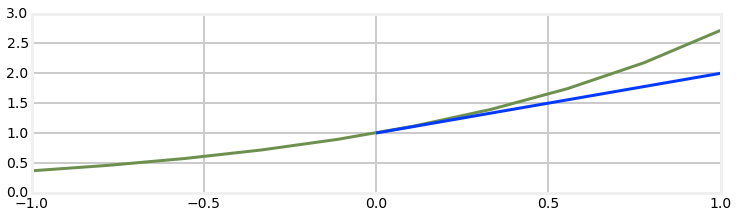

In [13]:
import numpy as np
import matplotlib.pyplot as plt
t = np.linspace(-1, 1, 10)
plt.plot(t, np.exp(t))
t = np.linspace(0, 1, 2)
plt.plot(t,t+1);

If the curve is relatively straight than the line formed by the slope will not be very far from the curve. Here the step size of 1 is rather large. You can see that the slope is very close to the line at $t=0.1$ but far at $t=1$. But let's continue with a step size of 1 for a moment. We can see that at $t=1$ the estimated value of $y$ is 2. Now we can compute the value at $t=2$ by taking the slope of the curve at $t=1$ and adding it to our initial estimate. The slope is computed with $y'=y$, so the slope is 2.

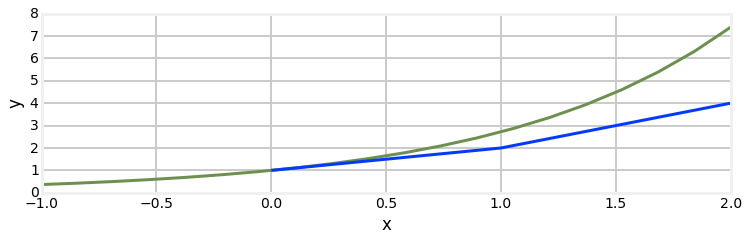

In [14]:
import book_plots
t = np.linspace(-1, 2, 20)
plt.plot(t, np.exp(t))
t = np.linspace(0, 1, 2)
plt.plot([1, 2, 4])
book_plots.set_labels(x='x', y='y');

Here we see the next estimate for y is 4. The errors are quickly getting large, and you might be unimpressed. But 1 is a very large step size. Let's put this algorithm in code, and verify that it works by trying to generate the result above.

In [15]:
def euler(t, tmax, y, dx, step=1.):
    ys = []
    while t < tmax:
        y = y + step*dx(t, y)
        ys.append(y)
        t +=step        
    return ys

In [16]:
def dx(t, y): return y

print(euler(0, 1, 1, dx, step=1.)[-1])
print(euler(0, 2, 1, dx, step=1.)[-1])

2.0
4.0


This looks correct. So now lets plot the result of a much smaller step size.

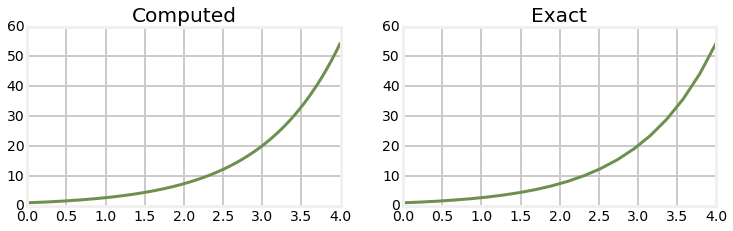

In [17]:
ys = euler(0, 4, 1, dx, step=0.00001)
plt.subplot(1,2,1)
plt.title('Computed')
plt.plot(np.linspace(0, 4, len(ys)),ys)
plt.subplot(1,2,2)
t = np.linspace(0, 4, 20)
plt.title('Exact')
plt.plot(t, np.exp(t));

In [18]:
print('exact answer=', np.exp(4))
print('euler answer=', ys[-1])
print('difference =', np.exp(4) - ys[-1])
print('iterations =', len(ys))

exact answer= 54.5981500331
euler answer= 54.59705808834125
difference = 0.00109194480299
iterations = 400000


Here we see that the error is reasonably small, but it took a very large number of iterations to get three digits of precision. In practice Euler's method is too slow for most problems, and we use higher level methods.

Before we go on, let's formally derive Euler's method, as it is the basis for the more advanced Runge Kutta methods used in the next section. In fact, Euler's method is the simplest form of Runge Kutta.


Here are the first 3 terms of the Euler expansion of $y$. An infinite expansion would give an exact answer, so $O(h^4)$ denotes the error due to the finite expansion.

$$y(t_0 + h) = y(t_0) + h y'(t_0) + \frac{1}{2!}h^2 y''(t_0) + \frac{1}{3!}h^3 y'''(t_0) +  O(h^4)$$

Here we can see that Euler's method is using the first two terms of the Taylor expansion. Each subsequent term is smaller than the previous terms, so we are assured that the estimate will not be too far off from the correct value. 

### Runge Kutta Methods


Runge Kutta integration is the workhorse of numerical integration. As mentioned earlier there are a vast number of methods in the literature. In practice, using the Runge Kutta algorithm that I present here will solve most any problem you will face. It offers a very good balance of speed, precision, and stability, and it is the 'go to' numerical integration method unless you have a very good reason to choose something different. If you have the knowledge to make that decision you have no need to be reading this section!

Let's dive in. We start with some differential equation

$$\ddot{y} = \frac{d}{dt}\dot{y}$$.

We can substitute the derivative of y with a function f, like so

$$\ddot{y} = \frac{d}{dt}f(y,t)$$.

Deriving these equations is outside the scope of this book, but the Runge Kutta RK4 method is defined with these equations.

$$y(t+\Delta t) = y(t) + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4) + O(\Delta t^4)$$

$$\begin{aligned}
k_1 &= f(y,t)\Delta t \\
k_2 &= f(y+\frac{1}{2}k_1, t+\frac{1}{2}\Delta t)\Delta t \\
k_3 &= f(y+\frac{1}{2}k_2, t+\frac{1}{2}\Delta t)\Delta t \\
k_4 &= f(y+k_3, t+\Delta t)\Delta t
\end{aligned}
$$


In [19]:
def runge_kutta4(y, x, dx, f):
    """computes 4th order Runge-Kutta for dy/dx.
    y is the initial value for y
    x is the initial value for x
    dx is the difference in x (e.g. the time step)
    f is a callable function (y, x) that you supply 
    to compute dy/dx for the specified values.
    """
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

Let's use this for a simple example. Let

$$\dot{y} = t\sqrt{y(t)}$$

with the initial values

$$\begin{aligned}t_0 &= 0\\y_0 &= y(t_0) = 1\end{aligned}$$

max error 5.206970035942504e-05


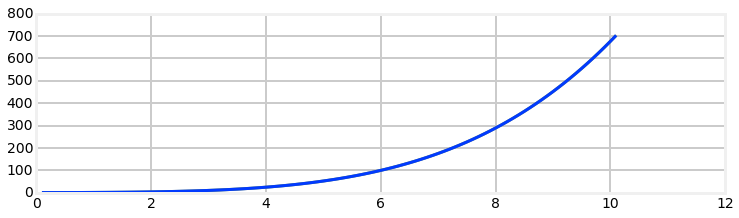

In [20]:
import math
import numpy as np
t = 0.
y = 1.
dt = .1

ys, ts = [], []

def func(y,t):
    return t*math.sqrt(y)

while t <= 10:
    y = runge_kutta4(y, t, dt, func)
    t += dt

    ys.append(y)
    ts.append(t)

exact = [(t**2 + 4)**2 / 16. for t in ts]
plt.plot(ts, ys)
plt.plot(ts, exact)

error = np.array(exact) - np.array(ys)
print("max error {}".format(max(error)))

## Converting the Multivariate Equations to the Univariate Case

The multivariate Kalman filter equations do not resemble the equations for the univariate filter. However, if we use one dimensional states and measurements the equations do reduce to the univariate equations. This section will provide you with a strong intuition into what the Kalman filter equations are actually doing. While reading this section is not required to understand the rest of the book, I recommend reading this section carefully as it should make the rest of the material easier to understand.

Here are the multivariate equations for the prediction. 

$$
\begin{aligned}
\mathbf{\bar{x}} &= \mathbf{F x} + \mathbf{B u} \\
\mathbf{\bar{P}} &= \mathbf{FPF}^\mathsf{T} + \mathbf Q
\end{aligned}
$$

For a univariate problem the state $\mathbf x$ only has one variable, so it is a $1\times 1$ matrix. Our motion $\mathbf{u}$ is also a $1\times 1$ matrix. Therefore, $\mathbf{F}$ and $\mathbf B$ must also be $1\times 1$ matrices. That means that they are all scalars, and we can write

$$\bar{x} = Fx + Bu$$

Here the variables are not bold, denoting that they are not matrices or vectors. 

Our state transition is simple - the next state is the same as this state, so $F=1$. The same holds for the motion transition, so, $B=1$. Thus we have

$$x = x + u$$

which is equivalent to the Gaussian equation from the last chapter

$$ \mu = \mu_1+\mu_2$$

Hopefully the general process is clear, so now I will go a bit faster on the rest. We have

$$\mathbf{\bar{P}} = \mathbf{FPF}^\mathsf{T} + \mathbf Q$$

Again, since our state only has one variable $\mathbf P$ and $\mathbf Q$ must also be $1\times 1$ matrix, which we can treat as scalars, yielding  

$$\bar{P} = FPF^\mathsf{T} + Q$$

We already know $F=1$. The transpose of a scalar is the scalar, so $F^\mathsf{T} = 1$. This yields

$$\bar{P} = P + Q$$

which is equivalent to the Gaussian equation of 

$$\sigma^2 = \sigma_1^2 + \sigma_2^2$$

This proves that the multivariate prediction equations are performing the same math as the univariate equations for the case of the dimension being 1.

These are the equations for the update step:

$$
\begin{aligned}
\mathbf{K}&= \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} \\
\textbf{y} &= \mathbf z - \mathbf{H \bar{x}}\\
\mathbf x&=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} \\
\mathbf P&= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}}
\end{aligned}
$$

As above, all of the matrices become scalars. $H$ defines how we convert from a position to a measurement. Both are positions, so there is no conversion, and thus $H=1$. Let's substitute in our known values and convert to scalar in one step. The inverse of a 1x1 matrix is the reciprocal of the value so we will convert the matrix inversion to division.

$$
\begin{aligned}
K &=\frac{\bar{P}}{\bar{P} + R} \\
y &= z - \bar{x}\\
x &=\bar{x}+Ky \\
P &= (1-K)\bar{P}
\end{aligned}
$$

Before we continue with the proof, I want you to look at those equations to recognize what a simple concept these equations implement. The residual $y$ is nothing more than the measurement minus the prediction. The gain $K$ is scaled based on how certain we are about the last prediction vs how certain we are about the measurement. We choose a new state $x$ based on the old value of $x$ plus the scaled value of the residual. Finally, we update the uncertainty based on how certain we are about the measurement. Algorithmically this should sound exactly like what we did in the last chapter.

Let's finish off the algebra to prove this. Recall that the univariate equations for the update step are:

$$
\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}}
\end{aligned}
$$

Here we will say that $\mu_1$ is the state $x$, and $\mu_2$ is the measurement $z$. Thus it follows that that $\sigma_1^2$ is the state uncertainty $P$, and $\sigma_2^2$ is the measurement noise $R$. Let's substitute those in.

$$ \mu = \frac{Pz + Rx}{P+R} \\
\sigma^2 = \frac{1}{\frac{1}{P} + \frac{1}{R}}
$$

I will handle $\mu$ first. The corresponding equation in the multivariate case is

$$
\begin{aligned}
x &= x + Ky \\
&= x + \frac{P}{P+R}(z-x) \\
&= \frac{P+R}{P+R}x + \frac{Pz - Px}{P+R} \\
&= \frac{Px + Rx + Pz - Px}{P+R} \\
&= \frac{Pz + Rx}{P+R}
\end{aligned}
$$

Now let's look at $\sigma^2$. The corresponding equation in the multivariate case is

$$ 
\begin{aligned}
P &= (1-K)P \\
&= (1-\frac{P}{P+R})P \\
&= (\frac{P+R}{P+R}-\frac{P}{P+R})P \\
&= (\frac{P+R-P}{P+R})P \\
&= \frac{RP}{P+R}\\
&= \frac{1}{\frac{P+R}{RP}}\\
&= \frac{1}{\frac{R}{RP} + \frac{P}{RP}} \\
&= \frac{1}{\frac{1}{P} + \frac{1}{R}}
\quad\blacksquare
\end{aligned}
$$

We have proven that the multivariate equations are equivalent to the univariate equations when we only have one state variable. I'll close this section by recognizing one quibble - I hand waved my assertion that $H=1$ and $F=1$. In general we know this is not true. For example, a digital thermometer may provide measurement in volts, and we need to convert that to temperature, and we use $H$ to do that conversion. I left that issue out to keep the explanation as simple and streamlined as possible. It is very straightforward to add that generalization to the equations above, redo the algebra, and still have the same results.

## Converting Kalman Filter to a g-h Filter

I've stated that the Kalman filter is a form of the g-h filter. It just takes some algebra to prove it. It's more straightforward to do with the one dimensional case, so I will do that. Recall 

$$
\mu_{x}=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}
$$

which I will make more friendly for our eyes as:

$$
\mu_{x}=\frac{ya + xb} {a+b}
$$

We can easily put this into the g-h form with the following algebra

$$
\begin{aligned}
\mu_{x}&=(x-x) + \frac{ya + xb} {a+b} \\
\mu_{x}&=x-\frac{a+b}{a+b}x  + \frac{ya + xb} {a+b} \\ 
\mu_{x}&=x +\frac{-x(a+b) + xb+ya}{a+b} \\
\mu_{x}&=x+ \frac{-xa+ya}{a+b}  \\
\mu_{x}&=x+ \frac{a}{a+b}(y-x)\\
\end{aligned}
$$

We are almost done, but recall that the variance of estimate is given by 

$${\sigma_{x}^2} = \frac{1}{ \frac{1}{\sigma_1^2} +  \frac{1}{\sigma_2^2}}\\
= \frac{1}{ \frac{1}{a} +  \frac{1}{b}}
$$

We can incorporate that term into our equation above by observing that

$$ 
\begin{aligned}
\frac{a}{a+b} &= \frac{a/a}{(a+b)/a} = \frac{1}{(a+b)/a}  \\
 &= \frac{1}{1 + \frac{b}{a}} = \frac{1}{\frac{b}{b} + \frac{b}{a}}  \\
 &= \frac{1}{b}\frac{1}{\frac{1}{b} + \frac{1}{a}} \\
 &= \frac{\sigma^2_{x'}}{b}
 \end{aligned}
$$

We can tie all of this together with

$$
\begin{aligned}
\mu_{x}&=x+ \frac{a}{a+b}(y-x) \\
&= x + \frac{\sigma^2_{x'}}{b}(y-x) \\
&= x + g_n(y-x)
\end{aligned}
$$

where

$$g_n = \frac{\sigma^2_{x}}{\sigma^2_{y}}$$

The end result is multiplying the residual of the two measurements by a constant and adding to our previous value, which is the $g$ equation for the g-h filter. $g$ is the variance of the new estimate divided by the variance of the measurement. Of course in this case $g$ is not a constant as it varies with each time step as the variance changes. We can also derive the formula for $h$ in the same way. It is not a particularly illuminating derivation and I will skip it. The end result is

$$h_n = \frac{COV (x,\dot x)}{\sigma^2_{y}}$$

The takeaway point is that $g$ and $h$ are specified fully by the variance and covariances of the measurement and predictions at time $n$. In other words, we are picking a point between the measurement and prediction by a scale factor determined by the quality of each of those two inputs.

## Iterative Least Squares for Sensor Fusion (Optional)

A broad category of use for the Kalman filter is *sensor fusion*. For example, we might have a position sensor and a velocity sensor, and we want to combine the data from both to find an optimal estimate of state. In this section we will discuss a different case, where we have multiple sensors providing the same type of measurement. 

 The Global Positioning System (GPS) is designed so that at least 6 satellites are in view at any time at any point on the globe. The GPS receiver knows the location of the satellites in the sky relative to the Earth. At each epoch (instant in time) the receiver gets a signal from each satellite from which it can derive the *pseudorange* to the satellite. In more detail, the GPS receiver gets a signal identifying the satellite along with the time stamp of when the signal was transmitted. The GPS satellite has an atomic clock on board so this time stamp is extremely accurate. The signal travels at the speed of light, which is constant in a vacuum, so in theory the GPS should be able to produce an extremely accurate distance measurement to the measurement by measuring how long the signal took to reach the receiver. There are several problems with that. First, the signal is not traveling through a vacuum, but through the atmosphere. The atmosphere causes the signal to bend, so it is not traveling in a straight line. This causes the signal to take longer to reach the receiver than theory suggests. Second, the on board clock on the GPS *receiver* is not very accurate, so deriving an exact time duration is nontrivial. Third, in many environments the signal can bounce off of buildings, trees, and other objects, causing either a longer path or *multipaths*, in which case the receive receives both the original signal from space and the reflected signals. 

Let's look at this graphically. I will do this in 2D to make it easier to graph and see, but of course this will generalize to three dimensions. We know the position of each satellite and the range to each (the range is called the *pseudorange*; we will discuss why later). We cannot measure the range exactly, so there is noise associated with the measurement, which I have depicted with the thickness of the lines. Here is an example of four pseudorange readings from four satellites. I positioned them in a configuration which is unlikely for the actual GPS constellation merely to make the intersections easy to visualize. Also, the amount of error shown is not to scale with the distances, again to make it easier to see.

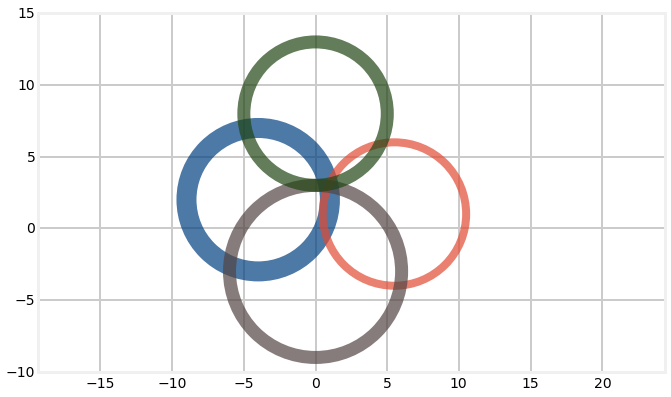

In [21]:
from book_format import set_figsize, figsize

import ukf_internal
with figsize(10, 6):
    ukf_internal.show_four_gps()

In 2D two measurements are sometimes enough to determine a unique solution. There are two intersections of the range circles, but often the second intersection is not physically realizable (it is in space, or under ground). However, with GPS we also need to solve for time, so we would need a third measurement to get a 2D position.

However, since GPS is a 3D system we need to solve for the 3 dimensions of space, and 1 dimension of time. That is 4 unknowns, so in theory with 4 satellites we have all the information we need. However, we normally have at least 6 satellites in view, and often more than 6. This means the system is *overdetermined*. Finally, because of the noise in the measurements none of pseudoranges intersect exactly.

If you are well versed in linear algebra you know that this an extremely common problem in scientific computing, and that there are various techniques for solving overdetermined systems. Probably the most common approach used by GPS receivers to find the position is the *iterative least squares* algorithm, commonly abbreviated ILS. As you know, if the errors are Gaussian then the least squares algorithm finds the optimal solution. In other words, we want to minimize the square of the residuals for an overdetermined system.

Let's start with some definitions which should be familiar to you. First, we define the innovation as 

$$\delta \mathbf{\bar{z}}= \mathbf z - h(\mathbf{\bar{x}})$$

where $\mathbf z$ is the measurement, $h(\bullet)$ is the measurement function, and $\delta \mathbf{\bar{z}}$ is the innovation, which we abbreviate as $y$ in FilterPy. In other words, this is the equation $\mathbf{y} = \mathbf z - \mathbf{H\bar{x}}$ in the linear Kalman filter's update step.

Next, the *measurement residual* is

$$\delta \mathbf z^+ = \mathbf z - h(\mathbf x^+)$$

I don't use the plus superscript much because I find it quickly makes the equations unreadable, but $\mathbf x^+$ is the *a posteriori* state estimate, which is the predicted or unknown future state. In other words, the predict step of the linear Kalman filter computes this value. Here it is stands for the value of x which the ILS algorithm will compute on each iteration.

These equations give us the following linear algebra equation:

$$\delta \mathbf z^- = \mathbf H\delta \mathbf x + \delta \mathbf z^+$$

$\mathbf H$ is our measurement function, defined as

$$\mathbf H = \frac{d\mathbf H}{d\mathbf x} = \frac{d\mathbf z}{d\mathbf x}$$

We find the minimum of an equation by taking the derivative and setting it to zero. In this case we want to minimize the square of the residuals, so our equation is

$$ \frac{\partial}{\partial \mathbf x}({\delta \mathbf z^+}^\mathsf{T}\delta \mathbf z^+) = 0,$$

where

$$\delta \mathbf z^+=\delta \mathbf z^- - \mathbf H\delta \mathbf x.$$

Here I have switched to using the matrix $\mathbf H$ as the measurement function. We want to use linear algebra to peform the ILS, so for each step we will have to compute the matrix $\mathbf H$ which corresponds to $h(\mathbf{x^-})$ during each iteration.  $h(\bullet)$ is usually nonlinear for these types of problems so you will have to linearize it at each step (more about this soon).

For various reasons you may want to weigh some measurement more than others. For example, the geometry of the problem might favor orthogonal measurements, or some measurements may be more noisy than others. We can do that with the equation

$$ \frac{\partial}{\partial \mathbf x}({\delta \mathbf z^+}^\mathsf{T}\mathbf{W}\delta \mathbf z^+) = 0$$

If we solve the first equation for ${\delta \mathbf x}$ (the derivation is shown in the next section) we get

$${\delta \mathbf x} = {{(\mathbf H^\mathsf{T}\mathbf H)^{-1}}\mathbf H^\mathsf{T} \delta \mathbf z^-}
$$

And the second equation yields

$${\delta \mathbf x} = {{(\mathbf H^\mathsf{T}\mathbf{WH})^{-1}}\mathbf H^\mathsf{T}\mathbf{W} \delta \mathbf z^-}
$$

Since the equations are overdetermined we cannot solve these equations exactly so we use an iterative approach. An initial guess for the position is made, and this guess is used to compute  for $\delta \mathbf x$ via the equation above. $\delta \mathbf x$ is added to the intial guess, and this new state is fed back into the equation to produce another $\delta \mathbf x$. We iterate in this manner until the difference in the measurement residuals is suitably small.

### Derivation of ILS Equations (Optional)

I will implement the ILS in code, but first let's derive the equation for $\delta \mathbf x$. You can skip the derivation if you want, but it is somewhat instructive and not too hard if you know basic linear algebra and partial differential equations.

Substituting $\delta \mathbf z^+=\delta \mathbf z^- - \mathbf H\delta \mathbf x$ into the partial differential equation we get

$$ \frac{\partial}{\partial \mathbf x}(\delta \mathbf z^- -\mathbf H \delta \mathbf x)^\mathsf{T}(\delta \mathbf z^- - \mathbf H \delta \mathbf x)=0$$

which expands to

$$ \frac{\partial}{\partial \mathbf x}({\delta \mathbf x}^\mathsf{T}\mathbf H^\mathsf{T}\mathbf H\delta \mathbf x - 
{\delta \mathbf x}^\mathsf{T}\mathbf H^\mathsf{T}\delta \mathbf z^- - 
{\delta \mathbf z^-}^\mathsf{T}\mathbf H\delta \mathbf x +
{\delta \mathbf z^-}^\mathsf{T}\delta \mathbf z^-)=0$$

We know that 

$$\frac{\partial \mathbf{A}^\mathsf{T}\mathbf B}{\partial \mathbf B} = \frac{\partial \mathbf B^\mathsf{T}\mathbf{A}}{\partial \mathbf B} = \mathbf{A}^\mathsf{T}$$

Therefore the third term can be computed as

$$\frac{\partial}{\partial \mathbf x}{\delta \mathbf z^-}^\mathsf{T}\mathbf H\delta \mathbf x = {\delta \mathbf z^-}^\mathsf{T}\mathbf H$$

and the second term as

$$\frac{\partial}{\partial \mathbf x}{\delta \mathbf x}^\mathsf{T}\mathbf H^\mathsf{T}\delta \mathbf z^-={\delta \mathbf z^-}^\mathsf{T}\mathbf H$$

We also know that
$$\frac{\partial \mathbf B^\mathsf{T}\mathbf{AB}}{\partial \mathbf B} = \mathbf B^\mathsf{T}(\mathbf{A} + \mathbf{A}^\mathsf{T})$$

Therefore the first term becomes

$$
\begin{aligned}
\frac{\partial}{\partial \mathbf x}{\delta \mathbf x}^\mathsf{T}\mathbf H^\mathsf{T}\mathbf H\delta \mathbf x &= {\delta \mathbf x}^\mathsf{T}(\mathbf H^\mathsf{T}\mathbf H + {\mathbf H^\mathsf{T}\mathbf H}^\mathsf{T})\\
&= {\delta \mathbf x}^\mathsf{T}(\mathbf H^\mathsf{T}\mathbf H + \mathbf H^\mathsf{T}\mathbf H) \\
&= 2{\delta \mathbf x}^\mathsf{T}\mathbf H^\mathsf{T}\mathbf H
\end{aligned}$$

Finally, the fourth term is

$$ \frac{\partial}{\partial \mathbf x}
{\delta \mathbf z^-}^\mathsf{T}\delta \mathbf z^-=0$$

Replacing the terms in the expanded partial differential equation gives us

$$
 2{\delta \mathbf x}^\mathsf{T}\mathbf H^\mathsf{T}\mathbf H -
 {\delta \mathbf z^-}^\mathsf{T}\mathbf H - {\delta \mathbf z^-}^\mathsf{T}\mathbf H
 =0
$$

$${\delta \mathbf x}^\mathsf{T}\mathbf H^\mathsf{T}\mathbf H -
 {\delta \mathbf z^-}^\mathsf{T}\mathbf H = 0$$
 
$${\delta \mathbf x}^\mathsf{T}\mathbf H^\mathsf{T}\mathbf H =
 {\delta \mathbf z^-}^\mathsf{T}\mathbf H$$

Multiplying each side by $(\mathbf H^\mathsf{T}\mathbf H)^{-1}$ yields

$${\delta \mathbf x}^\mathsf{T} =
{\delta \mathbf z^-}^\mathsf{T}\mathbf H(\mathbf H^\mathsf{T}\mathbf H)^{-1}$$

Taking the transpose of each side gives

$${\delta \mathbf x} = ({{\delta \mathbf z^-}^\mathsf{T}\mathbf H(\mathbf H^\mathsf{T}\mathbf H)^{-1}})^\mathsf{T} \\
={{(\mathbf H^\mathsf{T}\mathbf H)^{-1}}^T\mathbf H^\mathsf{T} \delta \mathbf z^-} \\
={{(\mathbf H^\mathsf{T}\mathbf H)^{-1}}\mathbf H^\mathsf{T} \delta \mathbf z^-}
$$

For various reasons you may want to weigh some measurement more than others. We can do that with the equation

$$ \frac{\partial}{\partial \mathbf x}({\delta \mathbf z}^\mathsf{T}\mathbf{W}\delta \mathbf z) = 0$$

Replicating the math above with the added $\mathbf{W}$ term results in

$${\delta \mathbf x} = {{(\mathbf H^\mathsf{T}\mathbf{WH})^{-1}}\mathbf H^\mathsf{T}\mathbf{W} \delta \mathbf z^-}
$$

### Implementing Iterative Least Squares

Our goal is to implement an iterative solution to 
$${\delta \mathbf x} = {{(\mathbf H^\mathsf{T}\mathbf H)^{-1}}\mathbf H^\mathsf{T} \delta \mathbf z^-}
$$

First, we have to compute $\mathbf H$, where $\mathbf H =  d\mathbf z/d\mathbf x$. To keep the example small so the results are easier to interpret we will do this in 2D. Therefore for $n$ satellites $\mathbf H$ expands to

$$\mathbf H = \begin{bmatrix}
\frac{\partial p_1}{\partial x_1} & \frac{\partial p_1}{\partial y_1} \\
\frac{\partial p_2}{\partial x_2} & \frac{\partial p_2}{\partial y_2} \\
\vdots & \vdots \\
\frac{\partial p_n}{\partial x_n} & \frac{\partial p_n}{\partial y_n}
\end{bmatrix}$$

We will linearize $\mathbf H$ by computing the partial for $x$ as

$$ \frac{estimated\_x\_position - satellite\_x\_position}{estimated\_range\_to\_satellite}$$

The equation for $y$ just substitutes $y$ for $x$.

Then the algorithm is as follows.

    def ILS:
        guess position
        while not converged:
            compute range to satellites for current estimated position
            compute H linearized at estimated position
            compute new estimate delta from (H^T H)'H^T dz
            new estimate = current estimate + estimate delta
            check for convergence
            

In [22]:
import numpy as np
from numpy.linalg import norm, inv
from numpy.random import randn
from numpy import dot
import book_format

np.random.seed(1234)
user_pos = np.array([800, 200])


sat_pos = np.asarray(
    [[0, 1000],
     [0, -1000],
     [500, 500]], dtype=float)

def satellite_range(pos, sat_pos):
    """ Compute distance between position 'pos' and 
    the list of positions in sat_pos"""

    N = len(sat_pos)
    rng = np.zeros(N)

    diff = np.asarray(pos) - sat_pos

    for i in range(N):
        rng[i] = norm(diff[i])

    return norm(diff, axis=1)


def hx_ils(pos, sat_pos, range_est):
    """ compute measurement function where
    pos : array_like 
        2D current estimated position. e.g. (23, 45)
        
    sat_pos : array_like of 2D positions
        position of each satellite e.g. [(0,100), (100,0)]
        
    range_est : array_like of floats
        range to each satellite
    """
    
    N = len(sat_pos)
    H = np.zeros((N, 2))
    for j in range(N):
        H[j, 0] = (pos[0] - sat_pos[j, 0]) / range_est[j]
        H[j, 1] = (pos[1] - sat_pos[j, 1]) / range_est[j]
    return H


def lop_ils(zs, sat_pos, pos_est, hx, eps=1.e-6):
    """ iteratively estimates the solution to a set of
    measurement, given known transmitter locations"""
    pos = np.array(pos_est)

    with book_format.numpy_precision(precision=4):
        converged = False
        for i in range(20):
            r_est = satellite_range(pos, sat_pos)
            print('iteration:', i+1)

            H = hx(pos, sat_pos, r_est)        
            Hinv = inv(dot(H.T, H)).dot(H.T)

            # update position estimate
            y = zs - r_est
            print('innovation', y)

            Hy = np.dot(Hinv, y)
            pos = pos + Hy
            print('pos       {}\n\n'.format(pos))

            if max(abs(Hy)) < eps:
                converged = True
                break

    return pos, converged

# compute range to each sensor
rz = satellite_range(user_pos, sat_pos)

pos, converted = lop_ils(rz, sat_pos, (900, 90), hx=hx_ils)
print('Iterated solution: ', pos)

iteration: 1
innovation [-148.512    28.6789 -148.5361]
pos       [ 805.4175  205.2868]


iteration: 2
innovation [-0.1177 -7.4049 -0.1599]
pos       [ 800.04    199.9746]


iteration: 3
innovation [-0.0463 -0.001  -0.0463]
pos       [ 800.  200.]


iteration: 4
innovation [-0. -0. -0.]
pos       [ 800.  200.]


Iterated solution:  [ 800.  200.]


So let's think about this. The first iteration is essentially performing the computation that the linear Kalman filter computes during the update step:

$$\mathbf{y} = \mathbf z - \mathbf{Hx}\\
\mathbf x = \mathbf x + \mathbf{Ky}$$

where the Kalman gain equals one. You can see that despite the very inaccurate initial guess (900, 90) the computed value for $\mathbf x$, (805.4, 205.3), was very close to the actual value of (800, 200). However, it was not perfect. But after three iterations the ILS algorithm was able to find the exact answer. So hopefully it is clear why we use ILS instead of doing the sensor fusion with the Kalman filter - it gives a better result. Of course, we started with a very inaccurate guess; what if the guess was better?

In [23]:
pos, converted = lop_ils(rz, sat_pos, (801, 201), hx=hx_ils)
print('Iterated solution: ', pos)

iteration: 1
innovation [-0.0009 -1.3868 -0.0024]
pos       [ 800.0014  199.9991]


iteration: 2
innovation [-0.0016 -0.     -0.0016]
pos       [ 800.  200.]


iteration: 3
innovation [-0. -0. -0.]
pos       [ 800.  200.]


Iterated solution:  [ 800.  200.]


The first iteration produced a better estimate, but it still could be improved upon by iterating.

I injected no noise in the measurement to test and display the theoretical performance of the filter. Now let's see how it performs when we inject noise.

In [24]:
# add some noise
nrz = []
for z in rz:
    nrz.append(z + randn())
pos, converted = lop_ils(nrz, sat_pos, (601,198.3), hx=hx_ils)
print('Iterated solution: ', pos)

iteration: 1
innovation [ 129.8823  100.461   107.5398]
pos       [ 831.4474  186.1222]


iteration: 2
innovation [-31.6446  -7.4837 -30.7861]
pos       [ 800.3284  198.8076]


iteration: 3
innovation [-0.6041 -0.3813  0.3569]
pos       [ 799.948   198.6026]


iteration: 4
innovation [-0.4803  0.0004  0.4802]
pos       [ 799.9476  198.6025]


iteration: 5
innovation [-0.4802  0.0007  0.4803]
pos       [ 799.9476  198.6025]


Iterated solution:  [ 799.948  198.602]


Here we can see that the noise means that we no longer find the exact solution but we are still able to quickly converge onto a more accurate solution than the first iteration provides.

This is far from a complete coverage of the iterated least squares algorithm, let alone methods used in GNSS to compute positions from GPS pseudoranges. You will find a number of approaches in the literature, including QR decomposition, SVD, and other techniques to solve the overdetermined system. For a nontrivial task you will have to survey the literature and perhaps design your algorithm depending on your specific sensor configuration, the amounts of noise, your accuracy requirements, and the amount of computation you can afford to do.

## References

 * [1] *Matrix Exponential* http://en.wikipedia.org/wiki/Matrix_exponential 

 * [2] *LTI System Theory* http://en.wikipedia.org/wiki/LTI_system_theory
 
 * [3] C.F. van Loan, "Computing Integrals Involving the Matrix Exponential," IEEE Transactions Automatic Control, June 1978.